<a id="top"></a>
 <font size="5">BAPC</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

# Import

In [1]:
import os
import numpy as np
import pandas as pd
import pitsa_lite as pitsa
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# Workflow


- **Inputs**  
    - **Data** A time series consisting of a step function
    - **Base model** : constant function $f_{(a, b, c, A w, \phi)}(t) = a + bt + ct^2 + A \cos(wt+\phi)$ depending on a intercept parameter $\theta=(a, b, c, A w, \phi)$
    - **Correction model**: K-Neares-Neighboor (default) or LSTM  
- **BAPC**
- **Explainability**  
    - **Explanation**: vector $\Delta \theta$.
    - **Importance**: vector $I \theta $

# Input

In [2]:
csv_file = 'AirPassengers'

base_model_name = 'Sinusoidal'

#correction_model_name = 'KNN' # fast but less accurate forecast
correction_model_name = 'LSTM' # slow but more accurate forecast

# meta parameters
time_start = 0 # start time for training
period = 12 # seasonality period
n_train = 4*period # number of training samples
correction_window = period # correction window size
forecast_lenght = period # forecast lenght

# Folders

In [3]:
# Please enter the input data folder 
data_folder = '../../../2_data/processed/airline_passenger'

# Please enter the output figure folder
fig_base = '../../../4_results/figures'

# save the figures ?
save_fig = True

# current convention
notebook_name, _  = os.path.splitext(os.path.basename(globals()['__vsc_ipynb_file__']))
fig_folder = os.path.join(fig_base, notebook_name)

if save_fig and not os.path.exists(fig_folder):
    print('Folder {} was created'.format(fig_folder))
    os.mkdir(fig_folder)

# Data

Number of observations: 144, number of columns: 1
Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_data.png was saved


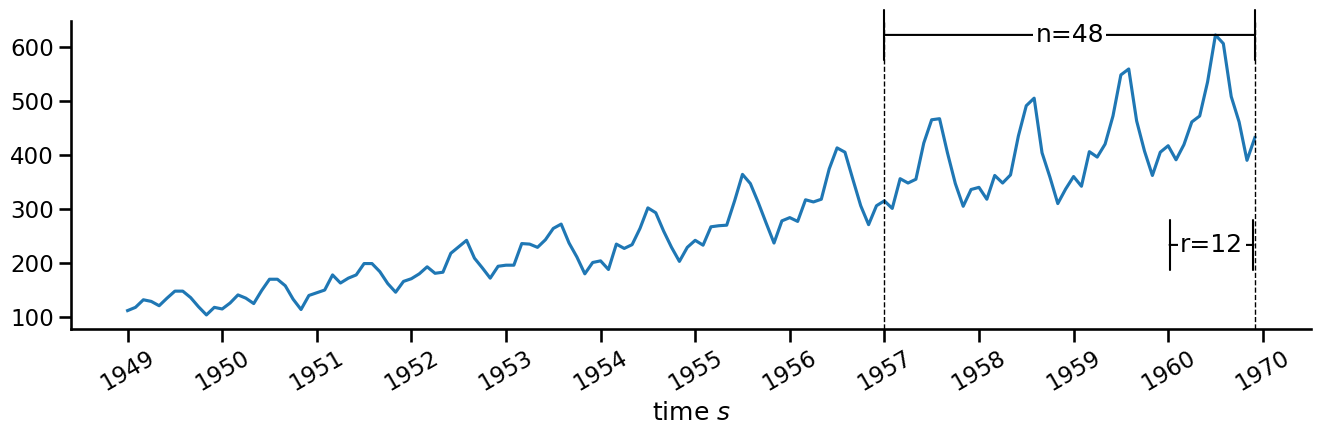

In [4]:
# time series reading
file_name = os.path.join(data_folder, 'airline_passenger.csv')
df = pd.read_csv(file_name, sep=',', decimal='.', index_col=0)
df.index = pd.to_datetime(df.index)
df.index.name = 't'
df.rename(columns={'Passengers': 'y'}, inplace=True)
print('Number of observations: {}, number of columns: {}'.format(df.shape[0], df.shape[1]))

# plot
#t = df.index.values
m_train = df.shape[0]

with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(16, 4))
    ax = plt.gca()

    time_stamps = df.index
    df.reset_index(inplace=True, drop=True)
    ax.plot(df.index, df['y'], color='tab:blue', label=r'$y$')

    ax.set_xlabel(r'time $s$')
    ax.set_ylabel('')

    x0 = m_train - n_train
    x1 = m_train - correction_window 
    x2 = m_train - 1

    plt.axvline(x0, color='black', linestyle='--', linewidth=1)
    plt.axvline(x2, color='black', linestyle='--', linewidth=1)

    ht = df['y'].max() 
    ax.annotate("", xy=(x0, ht), xytext=(x2, ht), textcoords=ax.transData, arrowprops=dict(arrowstyle='|-|',shrinkA=0, shrinkB=0))
    bbox=dict(fc="white", ec="none", boxstyle="square,pad=0.1")
    ax.text(x0 + (x2-x0)/2, ht, "n={}".format(n_train), ha="center", va="center", bbox=bbox);

    ht = df['y'].min() + 0.25*(df['y'].max()-df['y'].min()) 
    ax.annotate("", xy=(x1, ht), xytext=(x2, ht), textcoords=ax.transData, arrowprops=dict(arrowstyle='|-|',shrinkA=1, shrinkB=1))
    bbox=dict(fc="white", ec="none", boxstyle="square,pad=0.1")
    ax.text(x1 + (x2-x1)/2, ht, "r={}".format(correction_window), ha="center", va="center", bbox=bbox);

    xticks = np.arange(0, m_train+1, period)
    labels = list(time_stamps[xticks[:-1]].strftime('%Y')) + ['1970']
    ax.set_xticks(xticks, labels=labels, rotation=30)

    sns.despine()

    if save_fig:
        fig_name = os.path.join(fig_folder, '{}_data.png'.format(csv_file))
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
        print('Figure {} was saved'.format(fig_name))


# cast index and values to float
df = df.astype(float)
df.index = df.index.astype(float)
# #TODO deal with time index in the future

# Seasonal decomposition

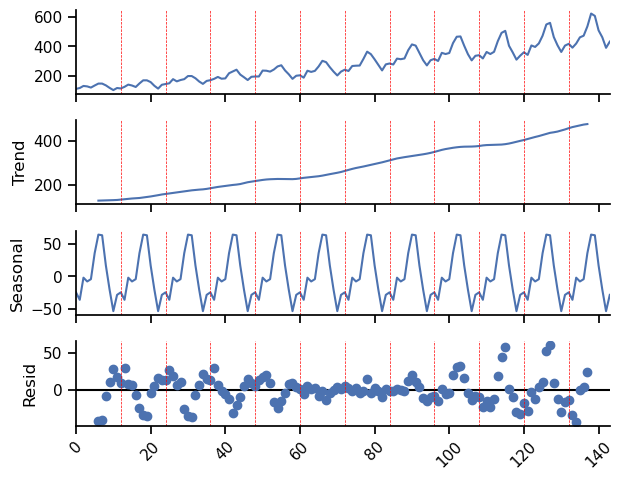

In [5]:
# seasonal decomposition. This is for exploratory purposes
decomposition = seasonal_decompose(df, model='additive', period=period)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

with sns.plotting_context("notebook"):
    decomposition.plot();

# plot vertival lines each 10 days
for ax in plt.gcf().get_axes():
    for i in range(period, len(df), period):
        ax.axvline(df.index[i], color='r', linestyle='--', lw=0.5)

#rotate x-axis labels
plt.xticks(rotation=45)
sns.despine()

# Base model

In [6]:
if base_model_name == 'Sinusoidal':
    frequency = 2*np.pi/period
    params_fixed = {"intercept":0, 'frequency':frequency} # TODO: get rid off intercept as a cosine parameter as it will be handled by the polynomial choespy
    params_init = {'amplitude':50, 'phase':0.0}
    fit_args = {'params_init': params_init, 'params_fixed': params_fixed}
    base_model = pitsa.models.regression.Sinusoidal(fit_args=fit_args)
else:
    error_msg = 'Model {} is not instantiated. Use this place to instantiate your new base model'.format(base_model_name)
    raise ValueError(error_msg)

# Correction model

In [7]:
if correction_model_name == 'KNN':
    model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
    correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')
    correction_model.ar_order = 0
elif correction_model_name == 'LSTM':
    fit_args={'epochs':400, 'verbose':False}
    ar_order = period
    SEED = 2022
    correction_model = pitsa.models.timeseries.RNN(model=None, ar_order=ar_order, fit_args=fit_args, name='LSTM')
    correction_model.initialize(lstm_units=16, SEED=SEED)

# Sequential BAPC

In [8]:
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                                          base_model=base_model, 
                                                          correction_model=correction_model, 
                                                          correction_windows=correction_window, 
                                                          n_train=n_train,
                                                          forecast_lenght=forecast_lenght)

# Explainability

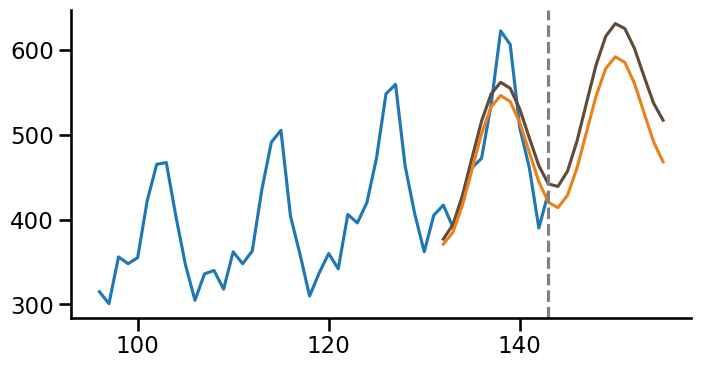

In [9]:
s = m_train - 1
c = explainers['y'][s][correction_window]
h = 0 # forecast horizon
t = s + h # forecast time

# simple plot
with sns.plotting_context("talk"):
    ax = pitsa.graphics.pltbapc.plot(c, figsize=(8, 4)) 
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=6)
    ax.axvline(x=t, color='gray', linestyle='--')
    sns.despine()

In [10]:
explanation, importance =  pitsa.xai.importance.explain_ig(c, t)

# check completness
t0 = int(c["t"][0])
surrogate_correction_at_t = np.array(c['first_base_model_at_t'])[t - time_start - t0] - np.array(c['second_base_model_at_t'])[t - time_start - t0]
tolerance = 1e-5
assert np.all(np.isclose(importance.sum(axis=1), surrogate_correction_at_t, atol=tolerance)), 'Sum of the importance ({}) is not equal to the total within the tolerance ({})'.format(importance.sum(axis=1), surrogate_correction_at_t)


# Heatmaps

In [11]:
# Create a dictionary to hold the DataFrames for each coefficient
cols = ['intercept', 'slope','quadratic', 'amplitude', 'phase']
coef_dict = {col: pd.DataFrame(np.nan, index=df.index.values, columns=df.index.values) for col in cols}
for df_coef in coef_dict.values():
    df_coef.index.name = 's'
    df_coef.columns.name = 't'

offset = 0

# Function to update the coefficient DataFrames
def update_coef_dfs(s, val, look_back, n_train, offset):
    c = val[look_back]
    t = np.arange(n_train) + offset
    explanation, importance = pitsa.xai.importance.explain_ig(c, t)
    for col in cols:
        coef_dict[col].loc[s, t] = importance[col].values
    return offset + 1

# Update the coefficient DataFrames
for s, val in explainers['y'].items():
    offset = update_coef_dfs(s, val, correction_window, n_train, offset)

coef_dict['sum'] = pd.DataFrame(0, index=df.index.values, columns=df.index.values)
coef_dict['sum'].index.name = 's'
coef_dict['sum'].columns.name = 't'
for col in cols:
    coef_dict['sum'] += coef_dict[col]


In [12]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def heatmaps(coef, levels, s):

    # re-indexing 
    coef = coef.rename(columns={k:k+1 for k in coef.columns})
    coef.rename(index={k:k+1 for k in coef.index}, inplace=True)
    coef = coef.T
    
    # subsetting
    coef = coef.loc[:, n_train:]

    v = coef.abs().max().max()
    vmin = -v
    vmax = v

    cmap = 'PiYG_r'
    cmap = cm.get_cmap(cmap)
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # heatmap
    f, ax = plt.subplots(figsize=(5, 5))
    X, Y = np.meshgrid(coef.columns, coef.index)
    Z = coef.values
    cs = ax.contourf(X, Y, Z, cmap=cmap, norm=norm, levels=levels)
    ax.contour(cs, colors='k', linewidths=0.5)
    ax.grid(c='k', ls='-', alpha=0.3)
    ax.set_xticks(xticks[4::2], labels=labels[4::2], rotation=30)
    ax.set_yticks(xticks[::2], labels=labels[::2])

    # # colorbar
    # ax_divider = make_axes_locatable(ax)
    # cax = ax_divider.append_axes("top", size="7%", pad="2%")
    # cbar = f.colorbar(cs, cax=cax, orientation="horizontal", ticks=[vmin, 0, vmax])
    # cax.xaxis.set_ticks_position("top")

    # heatmap
    bounds = np.linspace(vmin, vmax, levels-1)
    dv = 0.5*np.diff(bounds)[0]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="2%")
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', ticks=[vmin+dv, 0, vmax-dv])
    cbar.ax.set_xticklabels(['{:.0f}'.format(vmin), '0', '{:.0f}'.format(vmax)])	
    cax.xaxis.set_ticks_position("top")
  

    ax.set_xlabel('s')
    ax.set_ylabel('t')
    sns.despine()
   

    return f, ax

C:\Users\lopez\AppData\Local\Temp\ipykernel_15416\1609667973.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_heatmap_intercept.png was saved


C:\Users\lopez\AppData\Local\Temp\ipykernel_15416\1609667973.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_heatmap_slope.png was saved


C:\Users\lopez\AppData\Local\Temp\ipykernel_15416\1609667973.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_heatmap_quadratic.png was saved


C:\Users\lopez\AppData\Local\Temp\ipykernel_15416\1609667973.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_heatmap_amplitude.png was saved


C:\Users\lopez\AppData\Local\Temp\ipykernel_15416\1609667973.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_heatmap_phase.png was saved


C:\Users\lopez\AppData\Local\Temp\ipykernel_15416\1609667973.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


Figure ../../../4_results/figures\2_7_bapc_air_passengers\AirPassengers_heatmap_sum.png was saved


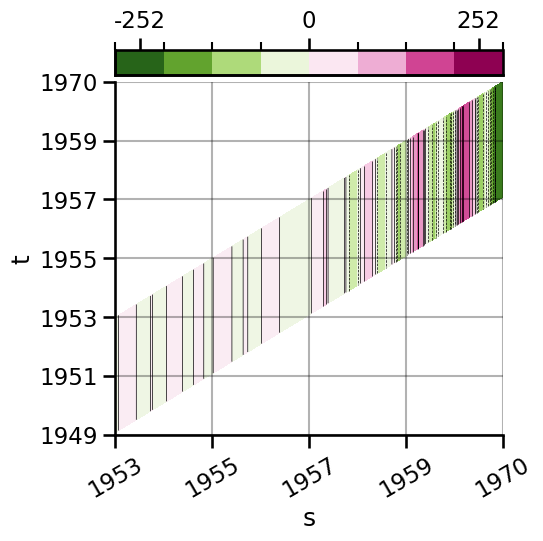

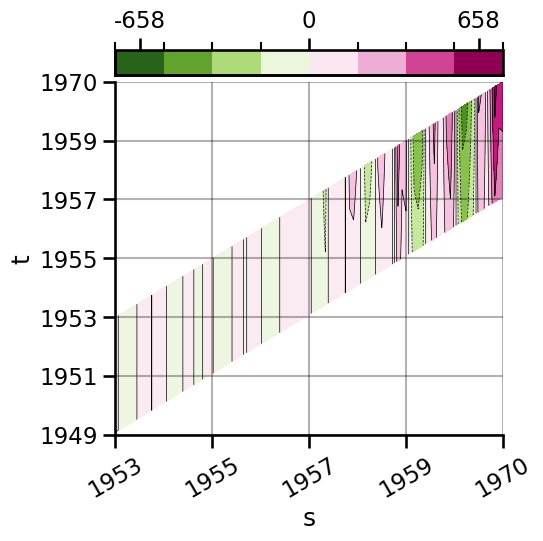

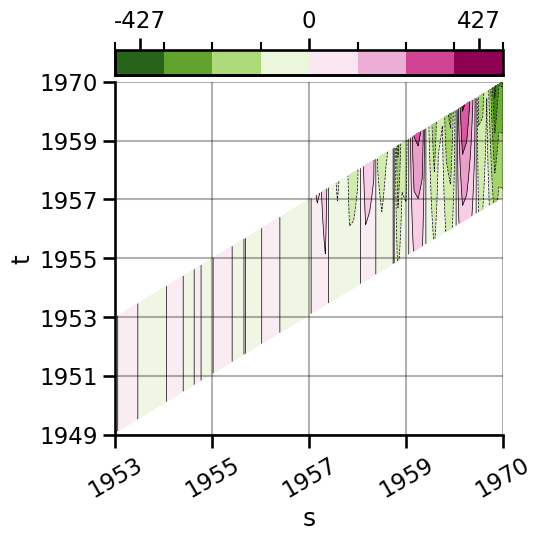

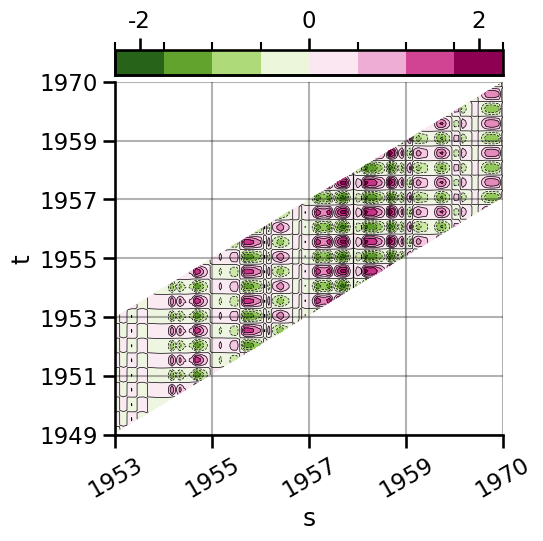

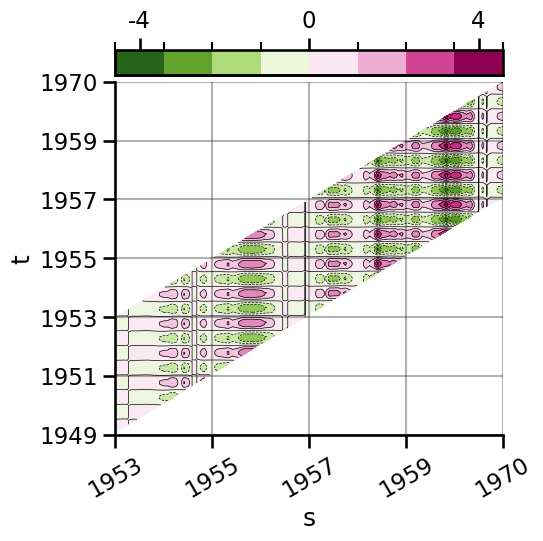

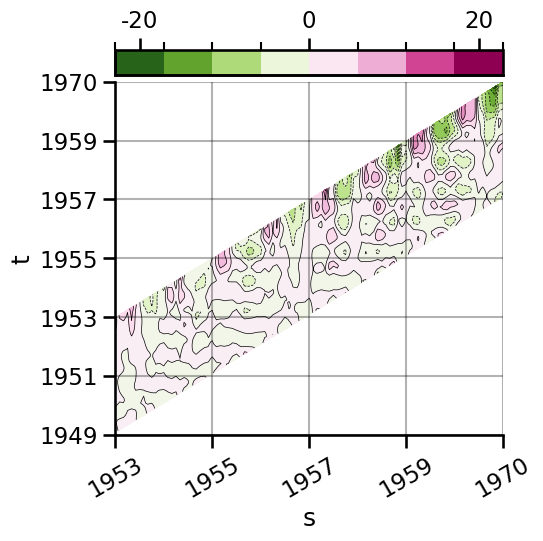

In [13]:
for key in coef_dict.keys():
    
    with sns.plotting_context("talk"):

        f, ax = heatmaps(coef_dict[key], levels=10, s=168)

        if save_fig:
            fig_name = os.path.join(fig_folder, '{}_heatmap_{}.png'.format(csv_file, key))
            plt.savefig(fig_name, bbox_inches='tight', dpi=300)
            print('Figure {} was saved'.format(fig_name))

# Bottom